# 03 - Hero Lane Outcomes
Extraction des stats early game par lane/hero.


In [2]:
import sys
from pathlib import Path

def _find_root():
    cand = Path.cwd()
    for c in [cand, *cand.parents]:
        if (c / 'src').exists() and (c / 'data').exists():
            return c
    return cand

ROOT = _find_root()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

processed_dir = ROOT / 'data/processed'
parquet_paths = [processed_dir / f for f in ['matches.parquet', 'players.parquet', 'objectives.parquet', 'teamfights.parquet']]
missing = [p for p in parquet_paths if not p.exists()]
if missing:
    raise FileNotFoundError(f"Parquets manquants: {missing}. Regenerer avec `make parquet`.")

import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.dota_data import read_processed_tables, lane_phase_features, match_header

sns.set_theme(style='whitegrid')

tables = read_processed_tables(processed_dir)
matches = match_header(tables['matches'])
players = tables['players']

minute = 10
lane_feats = lane_phase_features(players, minute=minute)
lane_df = lane_feats.to_pandas()
lane_df.head()
display(lane_df.shape)


(38790, 12)

In [3]:
lane_df

,match_id,player_slot,is_radiant,hero_id,lane,lane_role,gpm,xpm,lh_m10,dn_m10,gold_m10,xp_m10
0,8547022523,0,True,8,1.0,1.0,748,924,63.0,7.0,4239.0,3467.0
1,8547022523,1,True,38,2.0,2.0,673,910,52.0,15.0,3742.0,4250.0
2,8547022523,2,True,96,3.0,3.0,539,658,40.0,5.0,3325.0,3396.0
3,8547022523,3,True,101,3.0,3.0,325,539,12.0,1.0,1919.0,1563.0
4,8547022523,4,True,66,1.0,1.0,346,390,37.0,9.0,2308.0,2520.0
...,...,...,...,...,...,...,...,...,...,...,...,...
38785,8474083602,128,False,103,3.0,1.0,359,473,12.0,2.0,2448.0,2837.0
38786,8474083602,129,False,7,2.0,2.0,630,699,71.0,8.0,4730.0,5296.0
38787,8474083602,130,False,65,1.0,3.0,380,526,8.0,1.0,1783.0,2698.0
38788,8474083602,131,False,77,1.0,3.0,651,732,50.0,14.0,3451.0,3644.0


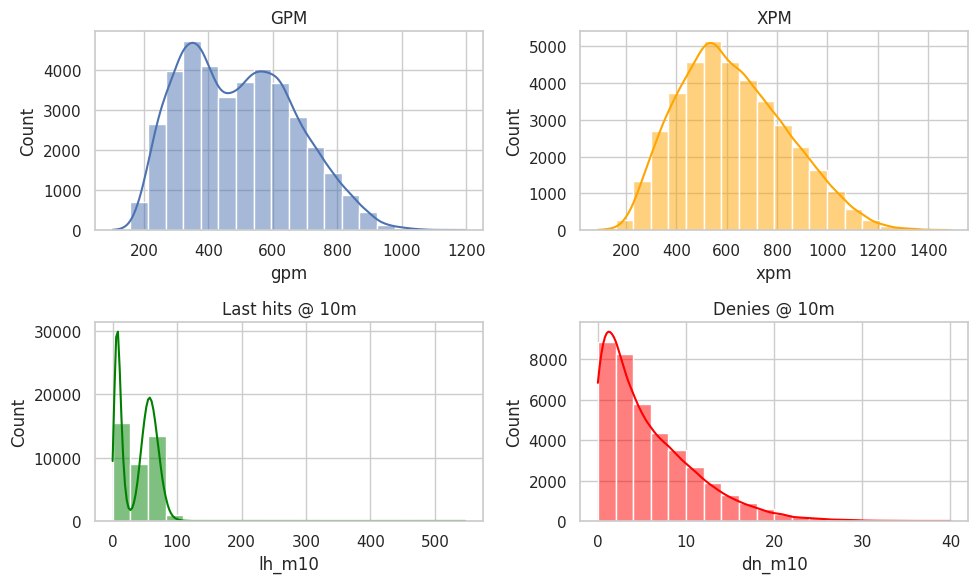

In [4]:
# Distributions GPM/XPM et LH/DN à 10 min
fig, axes = plt.subplots(2,2, figsize=(10,6))
sns.histplot(lane_df['gpm'].dropna(), bins=20, ax=axes[0,0], kde=True)
axes[0,0].set_title('GPM')
sns.histplot(lane_df['xpm'].dropna(), bins=20, ax=axes[0,1], kde=True, color='orange')
axes[0,1].set_title('XPM')
sns.histplot(lane_df[f'lh_m{minute}'].dropna(), bins=20, ax=axes[1,0], kde=True, color='green')
axes[1,0].set_title(f'Last hits @ {minute}m')
sns.histplot(lane_df[f'dn_m{minute}'].dropna(), bins=20, ax=axes[1,1], kde=True, color='red')
axes[1,1].set_title(f'Denies @ {minute}m')
plt.tight_layout()
plt.show()


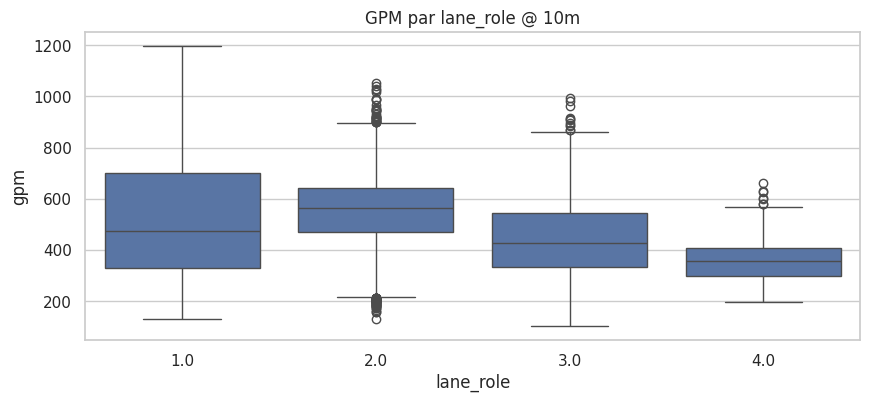

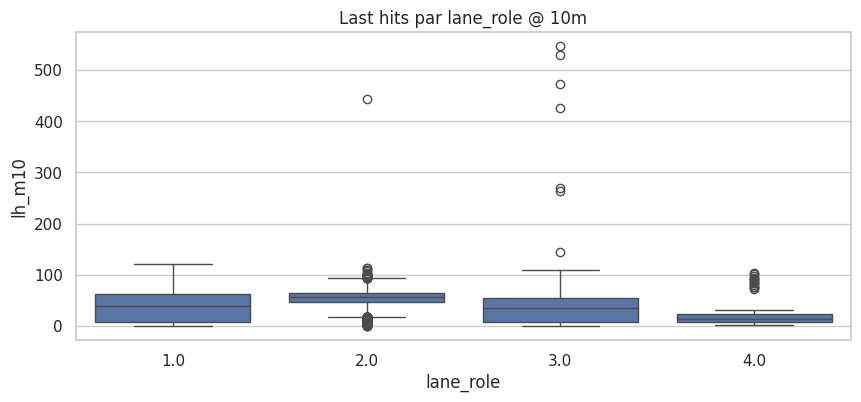

In [5]:
# Comparaison par lane_role (1=safe, 2=mid, 3=offlane, 4/5 supports)
plt.figure(figsize=(10,4))
sns.boxplot(data=lane_df, x='lane_role', y='gpm')
plt.title(f'GPM par lane_role @ {minute}m')
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(data=lane_df, x='lane_role', y=f'lh_m{minute}')
plt.title(f'Last hits par lane_role @ {minute}m')
plt.show()


In [6]:
# Top 10 heros par GPM moyen
top_gpm = lane_df.groupby('hero_id')['gpm'].mean().sort_values(ascending=False).head(10)
top_gpm


hero_id
48    751.375000
94    732.197368
46    727.765714
82    724.414634
8     716.303704
53    715.446078
73    714.513043
1     713.316456
18    708.576577
44    694.912234
Name: gpm, dtype: float64